In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os

from pinn.models.neural_net import PINN
from pinn.data.data_generator import load_normalized_data
from config import config
from utils import (
    plot_prediction_surface, compute_rmse, plot_loss_history,
    compute_errors, error_table, plot_final_time, plot_error_surface,
    compute_metrics, plot_prediction_vs_truth
)
from pinn.traditional.fd_solver import solve_heat_equation_fd
from pinn.scripts.robustness_eval import run_robustness_sweep, plot_robustness_curve
from gnn.models.gnn_model import GNNPredictor
from gnn.data.graph_dataset import build_static_graph
from torch_geometric.loader import DataLoader
from scipy.interpolate import griddata
from train import train_pinn, train_gnn
from torch.serialization import safe_globals
from torch_geometric.data import Data
from torch.serialization import add_safe_globals

In [3]:
# Train PINN from scratch if checkpoint is missing
if not os.path.exists(config["checkpoint_path"]):
    print("\n[INFO] Training PINN model from scratch...")
    train_pinn()
else:
    print("\n[INFO] PINN checkpoint found. Skipping training.")

**We load the trained PINN model using the architecture defined in neural_net.py. This allows evaluation on unseen test points.**

In [3]:
# Load trained model
print("\n[INFO] Loading trained PINN model...")
device = torch.device(config["device"])
model = PINN(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    hidden_layers=config["hidden_layers"],
    output_dim=config["output_dim"]
).to(device)
model.load_state_dict(torch.load(config["checkpoint_path"], map_location=device))
model.eval()

print(f"Model loaded from:", config["checkpoint_path"])


In [3]:
# Load test data
_, _, _, X_test, u_test = load_normalized_data(config["data_path"],
                                               n_collocation=config["n_collocation"],
                                               split_ratio=config["train_test_split"],
                                               device=device)

# Predict and compute RMSE
with torch.no_grad():
    u_pred = model(X_test)
    rmse = compute_rmse(u_pred, u_test, apply_expm1=True)
    print(f"RMSE on test set: {rmse:.6f}")

Loading and normalizing dataset from: D:/Programming/Summer-2025-DL-Project-PINN/data/covid_county_cases.csv
Loaded and processed: 856724 samples
Training points: 685379 | Test points: 171345 | Collocation points: 10000
RMSE on test set: 0.148810


**We compute RMSE to measure the model's generalization error on unseen spatiotemporal points**

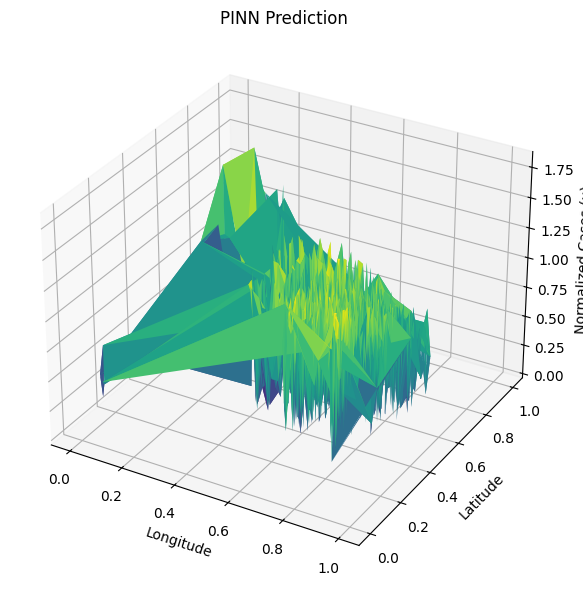

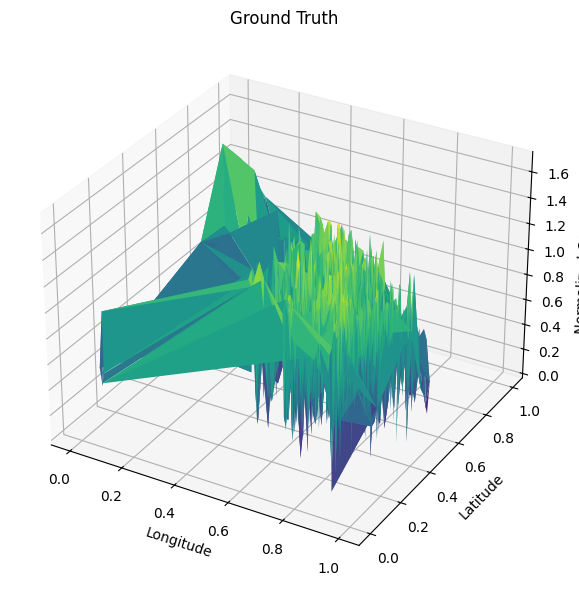

In [6]:
plot_prediction_surface(X_test, u_pred, title="PINN Prediction")
plot_prediction_surface(X_test, u_test, title="Ground Truth")

**This surface plot visualizes the predicted values of the normalized case count across 3D input space (lon, lat, time)**

In [4]:
errors = compute_errors(u_pred.cpu().numpy(), u_test.cpu().numpy())
display(error_table(errors))

,Metric,Value
0,Relative L2 Error,1.31e-01
1,Max Abs Error,4.85e-01


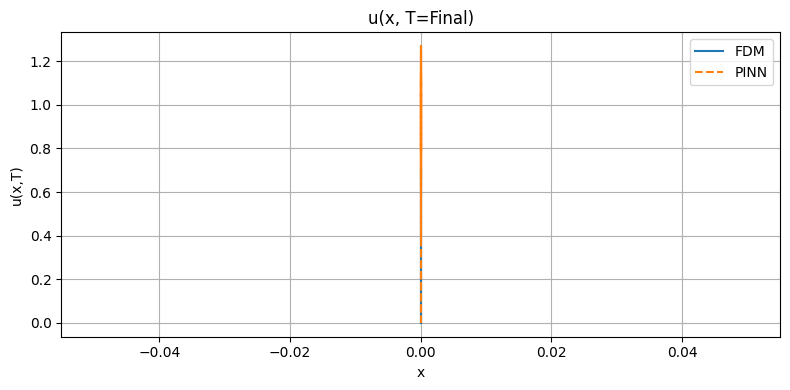

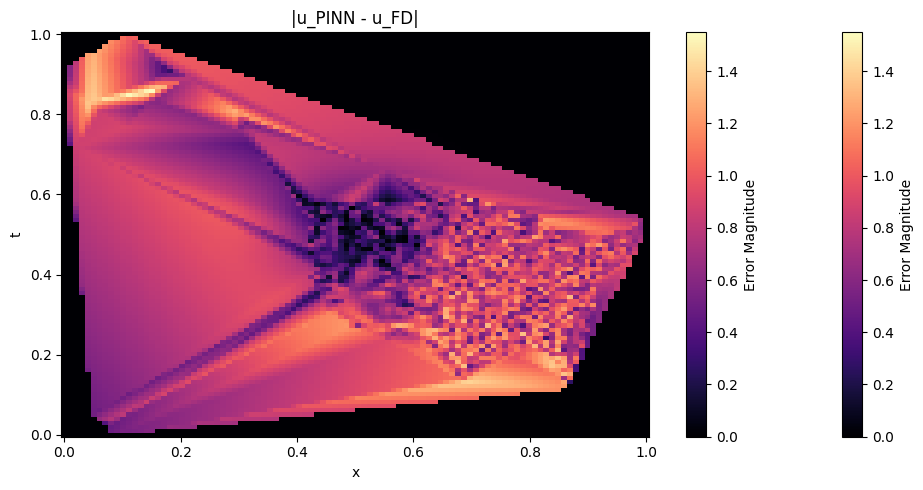

In [5]:
# PINN vs FD Comparison
fd_path = config["fd_path"]
if os.path.exists(fd_path):
    fd_data = np.load(fd_path)
    u_fd, X_fd, Y_fd = fd_data["u"], fd_data["X"], fd_data["Y"]
else:
    u_fd, X_fd, Y_fd = solve_heat_equation_fd(nx=100, ny=100, nt=100, T=1.0)
    np.savez_compressed(fd_path, u=u_fd, X=X_fd, Y=Y_fd)
u_fd = np.nan_to_num(u_fd, nan=0.0, posinf=0.0, neginf=0.0)
# Interpolate PINN prediction to FD grid
fd_coords = np.column_stack([X_fd.ravel(), Y_fd.ravel()])
u_pinn_interp = griddata(
    X_test.cpu().numpy()[:, :2],
    np.expm1(u_pred.cpu().numpy().flatten()),
    fd_coords,
    method='linear',
    fill_value=0.0  # or use np.nanmean(...) for average background
).reshape(X_fd.shape)


# Final time slice error
u_fd_final = u_fd[-1]
abs_error = np.abs(u_pinn_interp - u_fd_final)
plot_final_time(X_fd[0], u_fd_final[X_fd.shape[0]//2], u_pinn_interp[X_fd.shape[0]//2], T="Final")
plot_error_surface(X_fd, Y_fd, abs_error, title="|u_PINN - u_FD|")


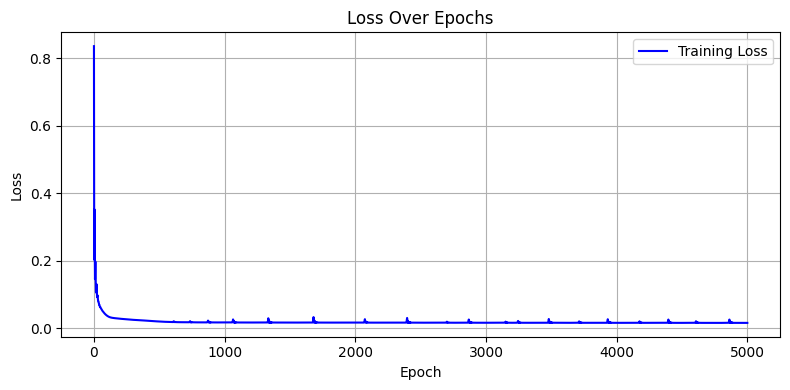

In [6]:
# Loss Curve
with open("checkpoints/loss_history.pkl", "rb") as f:
    loss_history = pickle.load(f)
plot_loss_history(loss_history)



[INFO] Evaluating GNN model...
[INFO] Matching counties by geometry...
[INFO] Filtering 5 unmatched nodes.
[INFO] Final valid graph samples: 516

[INFO] GNN model checkpoint found. Skipping training.
GNN RMSE: 0.8148, MAE: 0.4091


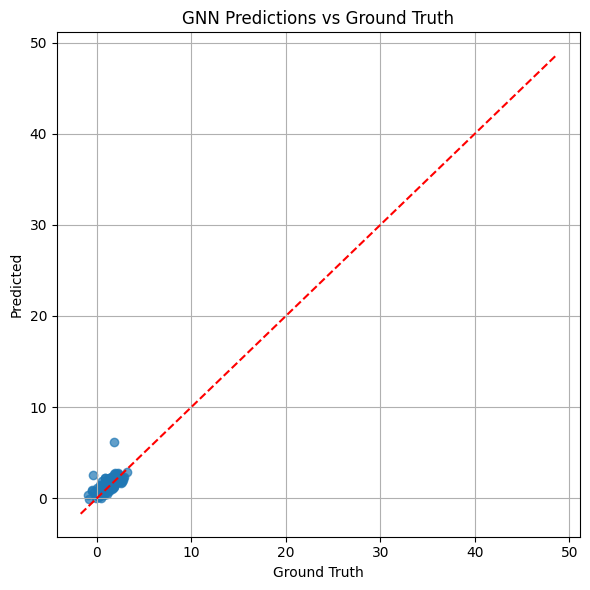

In [2]:
# Evaluate GNN model
print("\n[INFO] Evaluating GNN model...")
device = torch.device(config["device"])
data_path = config["gnn_dataset_path"]
if os.path.exists(data_path):
    # with safe_globals([Data]):
    add_safe_globals([torch_geometric.data.data.DataEdgeAttr])

    dataset, coords = torch.load(data_path, weights_only=False)
        # dataset, coords = torch.load(data_path, weights_only=False)

else:
    dataset, coords = build_static_graph(
        config["data_path"],
        config["shape_file_path"]
    )
    torch.save((dataset, coords), data_path)

split_idx = int(len(dataset) * config["train_test_split"])
test_data = dataset[split_idx:]
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

gnn_model = GNNPredictor(in_dim=3, hidden_dim=64, out_dim=1).to(device)
if not os.path.exists(config["gnn_model_path"]):
    print("\n[INFO] GNN checkpoint not found. Training GNN model now...")
    train_gnn()
else:
    print("\n[INFO] GNN model checkpoint found. Skipping training.")

gnn_model.load_state_dict(torch.load(config["gnn_model_path"], map_location=device))
gnn_model.eval()

preds, targets = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = gnn_model(batch.x, batch.edge_index).squeeze()
        preds.append(out.cpu().numpy())
        targets.append(batch.y.cpu().numpy())
preds = np.concatenate(preds)
targets = np.concatenate(targets)
metrics = compute_metrics(preds, targets)
print(f"GNN RMSE: {metrics['rmse']:.4f}, MAE: {metrics['mae']:.4f}")
plot_prediction_vs_truth(preds, targets)


In [3]:
# Run Robustness Sweep + Plot
print("\n[INFO] Running adversarial robustness sweep...")
results = run_robustness_sweep(epsilons=[0.0, 0.01, 0.02, 0.05], epochs=1000)
plot_robustness_curve(results)
df_results = pd.DataFrame.from_dict(results, orient="index")
display(df_results.round(4))

In [ ]:
# Cell 10: Summary Takeaway
from IPython.display import Markdown
Markdown("""
### 📌 Evaluation Summary

- **Test RMSE (PINN):** {:.4f}  
- **Test RMSE (GNN):** {:.4f}  
- **Relative L2 Error (PINN):** {:.4f}  
- **Max Abs Error (PINN):** {:.4f}  
- **PDE Residual (ε=0.0):** Mean = {:.2e}, Max = {:.2e}  

The PINN model approximates the PDE with low residuals and shows robustness to small perturbations. GNN offers competitive RMSE using a spatial graph of counties and is a viable data-driven alternative.
""".format(
    results[0.0]['rmse'],
    metrics['rmse'],
    results[0.0]['Relative L2 Error'],
    results[0.0]['Max Abs Error'],
    results[0.0]['mean_residual'],
    results[0.0]['max_residual']
))


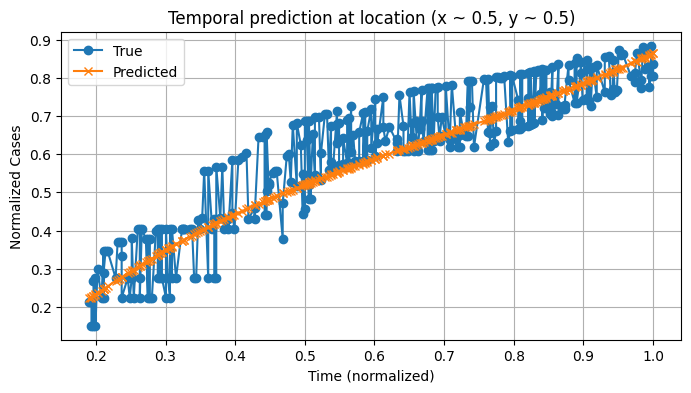

In [8]:
# Pick a location (x, y) close to [0.5, 0.5]
# Convert tensors to NumPy
X_test_np = X_test.cpu().numpy()
u_test_np = u_test.cpu().numpy()
u_pred_np = u_pred.cpu().numpy()
mask = np.abs(X_test_np[:, 0] - 0.5) < 0.01  # lon ~ 0.5
mask &= np.abs(X_test_np[:, 1] - 0.5) < 0.01  # lat ~ 0.5

x_slice = X_test_np[mask]
u_true_slice = u_test_np[mask]
u_pred_slice = u_pred_np[mask]

if len(x_slice) > 0:
    idx = np.argsort(x_slice[:, 2])  # sort by time
    plt.figure(figsize=(8, 4))
    plt.plot(x_slice[idx, 2], u_true_slice[idx], label="True", marker='o')
    plt.plot(x_slice[idx, 2], u_pred_slice[idx], label="Predicted", marker='x')
    plt.xlabel("Time (normalized)")
    plt.ylabel("Normalized Cases")
    plt.title("Temporal prediction at location (x ~ 0.5, y ~ 0.5)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No points found near (0.5, 0.5). Try adjusting location mask.")

**Here we visualize the predicted time evolution of COVID-19 cases at a fixed location to evaluate dynamic consistency**

**Run Finite Difference Solver**

In [9]:
u_fd, X_fd, Y_fd = solve_heat_equation_fd()

In [10]:
# Try loading pre-saved FD solution; generate if not found
fd_path = config["fd_path"]

if os.path.exists(fd_path):
    print("Loading FD solution from file...")
    fd_data = np.load(fd_path)
    u_fd = fd_data["u"]
    X_fd = fd_data["X"]
    Y_fd = fd_data["Y"]
else:
    print("FD solution not found. Generating it now...")
    from traditional.fd_solver import solve_heat_equation_fd
    u_fd, X_fd, Y_fd = solve_heat_equation_fd(nx=100, ny=100, nt=100, T=1.0)
    np.savez(fd_path, u=u_fd, X=X_fd, Y=Y_fd)
    print(f"FD solution saved to {fd_path}")


Loading FD solution from file...


In [11]:
from scipy.interpolate import griddata

# Flatten FD meshgrid to (N, 2)
fd_coords = np.column_stack([X_fd.ravel(), Y_fd.ravel()])

# Interpolate PINN predictions onto FD grid
u_pinn_interp = griddata(
    X_test.cpu().numpy()[:, :2], 
    np.expm1(u_pred.cpu().numpy().flatten()), 
    fd_coords, 
    method='linear'
).reshape(X_fd.shape)

# Compare to final time slice of FD
u_fd_final = u_fd[-1]


**Plot side-by-side comparison**

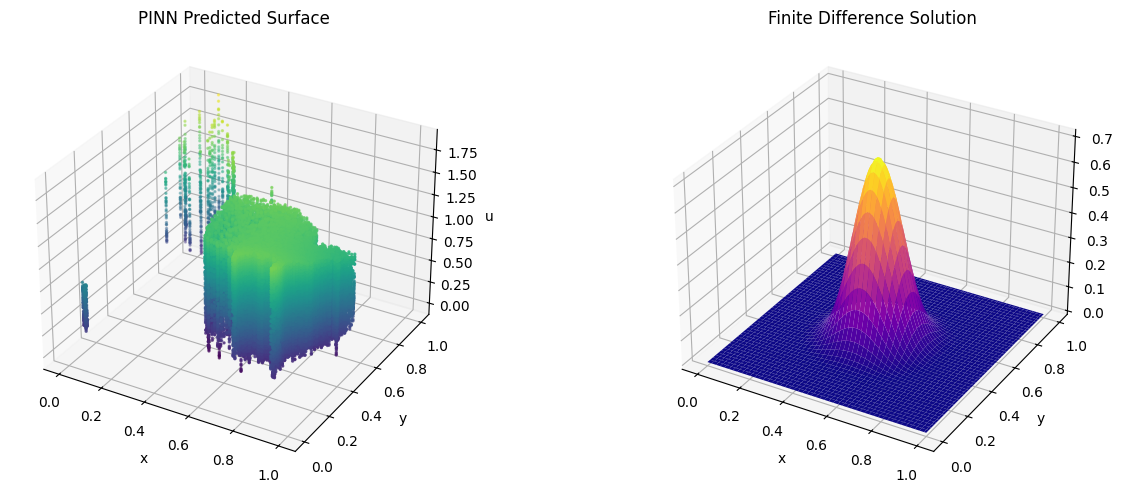

In [17]:
# Toggle to show or skip 3D surface comparison
show_3d_surface = True

if show_3d_surface:
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(14, 5))

    # Inverse log1p transformation if necessary
    u_plot = torch.expm1(u_pred).cpu().numpy() if isinstance(u_pred, torch.Tensor) else np.expm1(u_pred)
    X_np = X_test.cpu().numpy() if isinstance(X_test, torch.Tensor) else X_test

    # 3D Scatter of PINN predictions
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.scatter(
        X_np[:, 0], X_np[:, 1], u_plot[:, 0],
        c=u_plot[:, 0], cmap="viridis", s=2
    )
    ax1.set_title("PINN Predicted Surface")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_zlabel("u")

    # 3D Surface of FD solution
    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    ax2.plot_surface(
        X_fd, Y_fd, u_fd_final,
        cmap="plasma", edgecolor="none"
    )
    ax2.set_title("Finite Difference Solution")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("u")

    plt.tight_layout()
    plt.show()
